# Colabs

Machine Learning Crash Course uses Colaboratories (Colabs) for all programming exercises. Colab is Google's implementation of [Jupyter Notebook](https://jupyter.org/). For more information about Colabs and how to use them, go to [Welcome to Colaboratory](https://research.google.com/colaboratory).

# Cuadernos Colab

Machine Learning Crash Course utiliza Colaboratories (Colabs) para todos los ejercicios de programación. Colab es la implementación de Google de [Jupyter Notebook](https://jupyter.org/). Para obtener más información sobre Colabs y cómo utilizarlos, visita [Bienvenido a Colaboratory](https://research.google.com/colaboratory).

# Introduction to Neural Nets

This Colab builds a deep neural network to perform more sophisticated linear regression than the earlier Colabs.

# Introducción a Redes Neuronales

Este Colab construye una red neuronal profunda para realizar una regresión lineal más sofisticada que la realizada en los Colabs anteriores.

## Learning Objectives:

After doing this Colab, you'll know how to do the following:

  * Create a simple deep neural network.
  * Tune the hyperparameters for a simple deep neural network.


## Objetivos de Aprendizaje:

Después de realizar este Colab, sabrás cómo hacer lo siguiente:

  * Crear una red neuronal profunda simple.
  * Ajustar los hiperparámetros para una red neuronal profunda simple.

## The Dataset
  
Like several of the previous Colabs, this Colab uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## El Conjunto de Datos

Al igual que varios de los Colabs anteriores, este Colab utiliza el [Conjunto de Datos de Viviendas de California](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [2]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


## Load the dataset

Like most of the previous Colab exercises, this exercise uses the California Housing Dataset.  The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set
   

## Cargar el conjunto de datos

Al igual que en la mayoría de los ejercicios anteriores de Colab, este ejercicio utiliza el Conjunto de Datos de Viviendas de California. La siguiente celda de código carga los archivos .csv por separado y crea los siguientes dos DataFrames de pandas:

* `train_df`, que contiene el conjunto de entrenamiento
* `test_df`, que contiene el conjunto de prueba

In [3]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

## Represent data

The following code cell creates preprocessing layers outputting three features:

* `latitude` X `longitude` (a feature cross)
* `median_income`
* `population`

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `prepocessing_layers`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.

We'll use `preprocessing_layers` for both our linear regression model and our neural network model.

(The [`keras.FeatureSpace`](https://keras.io/examples/structured_data/structured_data_classification_with_feature_space) utility offers an alternative to building individual Keras preprocessing layers -- give it a try, if you're feeling adventurous!)


## Representar datos

La siguiente celda de código crea capas de preprocesamiento que producen tres características:

* `latitude` X `longitude` (una característica cruzada)
* `median_income`
* `population`

Esta celda de código especifica las características con las que entrenarás finalmente el modelo y cómo se representará cada una de esas características. Las transformaciones (recopiladas en `preprocessing_layers`) no se aplican realmente hasta que le pases un DataFrame, lo cual ocurrirá cuando entrenemos el modelo.

Utilizaremos `preprocessing_layers` tanto para nuestro modelo de regresión lineal como para nuestro modelo de red neuronal.

(El utilitario [`keras.FeatureSpace`](https://keras.io/examples/structured_data/structured_data_classification_with_feature_space) ofrece una alternativa para construir capas de preprocesamiento individuales en Keras; ¡pruébalo si te sientes aventurero!)

In [4]:
# Keras Input tensors of float values.
inputs = {
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude'),
    'median_income':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='median_income'),
    'population':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='population')
}

# Create a Normalization layer to normalize the median_income data.
median_income = tf.keras.layers.Normalization(
    name='normalization_median_income',
    axis=None)
median_income.adapt(train_df['median_income'])
median_income = median_income(inputs.get('median_income'))

# Create a Normalization layer to normalize the population data.
population = tf.keras.layers.Normalization(
    name='normalization_population',
    axis=None)
population.adapt(train_df['population'])
population = population(inputs.get('population'))

# Create a list of numbers representing the bucket boundaries for latitude.
# Because we're using a Normalization layer, values for latitude and longitude
# will be in the range of approximately -3 to 3 (representing the Z score).
# We'll create 20 buckets, which requires 21 bucket boundaries (hence, 20+1).
latitude_boundaries = np.linspace(-3, 3, 20+1)

# Create a Normalization layer to normalize the latitude data.
latitude = tf.keras.layers.Normalization(
    name='normalization_latitude',
    axis=None)
latitude.adapt(train_df['latitude'])
latitude = latitude(inputs.get('latitude'))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(latitude)

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = np.linspace(-3, 3, 20+1)

# Create a Normalization layer to normalize the longitude data.
longitude = tf.keras.layers.Normalization(
    name='normalization_longitude',
    axis=None)
longitude.adapt(train_df['longitude'])
longitude = longitude(inputs.get('longitude'))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(longitude)

# Cross the latitude and longitude features into a single one-hot vector.
feature_cross = tf.keras.layers.HashedCrossing(
    # num_bins can be adjusted: Higher values improve accuracy, lower values
    # improve performance.
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

# Concatenate our inputs into a single tensor.
preprocessing_layers = tf.keras.layers.Concatenate()(
    [feature_cross, median_income, population])

print("Preprocessing layers defined.")



Preprocessing layers defined.


## Build a linear regression model as a baseline

Before creating a deep neural net, find a [baseline](https://developers.google.com/machine-learning/glossary/#baseline) loss by running a simple linear regression model that uses the preprocessing layers you just created.

## Construir un modelo de regresión lineal como referencia

Antes de crear una red neuronal profunda, encuentra una [pérdida de referencia](https://developers.google.com/machine-learning/glossary/#baseline) ejecutando un modelo de regresión lineal simple que utilice las capas de preprocesamiento que acabas de crear.

In [5]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  # mse_training is a pandas Series, so convert it to a list first.
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [6]:
#@title Define functions to create and train a linear regression model
def create_model(my_inputs, my_outputs, my_learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = train_median_house_value_normalized(
      np.array(features.pop(label_name)))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [7]:
#@title Define normalized label columns
# Create Normalization layers to normalize the median_house_value data.
# Because median_house_value is our label (i.e., the target value we're
# predicting), these layers won't be added to our model.
train_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
train_median_house_value_normalized.adapt(
    np.array(train_df['median_house_value']))

test_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
test_median_house_value_normalized.adapt(
    np.array(test_df['median_house_value']))


In [8]:
#@title Define linear regression model outputs
def get_outputs_linear_regression():
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

Run the following code cell to invoke the functions defined in the preceding two code cells. (Ignore the warning messages.)

**Note:** Because we've scaled all the input data, **including the label**, the resulting loss values will be *much less* than models in previous Colabs (e.g., [Representation with a Feature Cross](https://colab.sandbox.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/representation_with_a_feature_cross.ipynb)).

**Note:** Depending on the version of TensorFlow, running this cell might generate WARNING messages. Please ignore these warnings.




Ejecuta la siguiente celda de código para invocar las funciones definidas en las dos celdas de código anteriores. (Ignora los mensajes de advertencia.)

**Nota:** Debido a que hemos escalado todos los datos de entrada, **incluida la etiqueta**, los valores de pérdida resultantes serán *mucho menores* que los modelos en Colabs anteriores (por ejemplo, [Representación con una Característica Cruzada](https://colab.sandbox.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/representation_with_a_feature_cross.ipynb)).

**Nota:** Dependiendo de la versión de TensorFlow, ejecutar esta celda podría generar mensajes de ADVERTENCIA. Por favor, ignora estas advertencias.

Epoch 1/15
14/14 [==============================] - 1s 16ms/step - loss: 0.8110 - mean_squared_error: 0.8110 - val_loss: 0.6615 - val_mean_squared_error: 0.6615
Epoch 2/15
14/14 [==============================] - 0s 5ms/step - loss: 0.5873 - mean_squared_error: 0.5873 - val_loss: 0.4917 - val_mean_squared_error: 0.4917
Epoch 3/15
14/14 [==============================] - 0s 4ms/step - loss: 0.4554 - mean_squared_error: 0.4554 - val_loss: 0.3999 - val_mean_squared_error: 0.3999
Epoch 4/15
14/14 [==============================] - 0s 5ms/step - loss: 0.3899 - mean_squared_error: 0.3899 - val_loss: 0.3575 - val_mean_squared_error: 0.3575
Epoch 5/15
14/14 [==============================] - 0s 5ms/step - loss: 0.3623 - mean_squared_error: 0.3623 - val_loss: 0.3399 - val_mean_squared_error: 0.3399
Epoch 6/15
14/14 [==============================] - 0s 5ms/step - loss: 0.3512 - mean_squared_error: 0.3512 - val_loss: 0.3326 - val_mean_squared_error: 0.3326
Epoch 7/15
14/14 [=====================

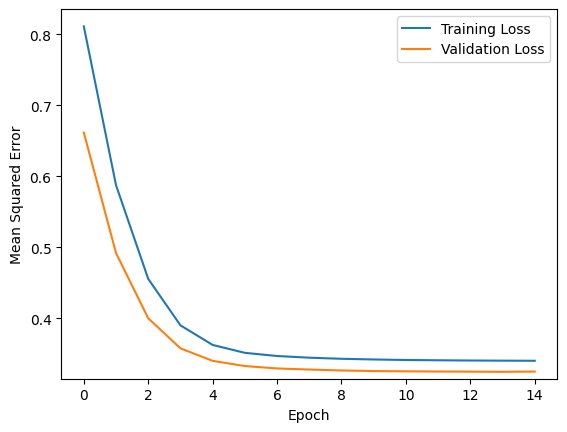


 Evaluate the linear regression model against the test set:
3/3 [==============================] - 0s 3ms/step - loss: 0.3607 - mean_squared_error: 0.3607


{'loss': 0.36074551939964294, 'mean_squared_error': 0.36074551939964294}

In [14]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size,
                          label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

## Define a deep neural net model

The `get_outputs_dnn` function defines the topography of the deep neural net (DNN), specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.

The `get_outputs_dnn` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.

The first `Dense` layer takes our previously defined `preprocessing_layers` as input.



## Definir un modelo de red neuronal profunda

La función `get_outputs_dnn` define la topografía de la red neuronal profunda (DNN), especificando lo siguiente:

* El número de [capas](https://developers.google.com/machine-learning/glossary/#layer) en la red neuronal profunda.
* El número de [nodos](https://developers.google.com/machine-learning/glossary/#node) en cada capa.

La función `get_outputs_dnn` también define la [función de activación](https://developers.google.com/machine-learning/glossary/#activation_function) de cada capa.

La primera capa `Dense` toma nuestras capas de preprocesamiento previamente definidas como entrada.

In [15]:
def get_outputs_dnn():
  # Create a Dense layer with 20 nodes.
  dense_output = tf.keras.layers.Dense(units=20,
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
  # Create a Dense layer with 12 nodes.
  dense_output = tf.keras.layers.Dense(units=12,
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(dense_output)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }

  return outputs

## Call the functions to build and train a deep neural net

Okay, it is time to actually train the deep neural net.  If time permits, experiment with the three hyperparameters to see if you can reduce the loss
against the test set.


## Llamar a las funciones para construir y entrenar una red neuronal profunda

Bien, es el momento de entrenar la red neuronal profunda. Si el tiempo lo permite, experimenta con los tres hiperparámetros para ver si puedes reducir la pérdida contra el conjunto de prueba.

Epoch 1/20
14/14 [==============================] - 1s 18ms/step - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.4113 - val_mean_squared_error: 0.4113
Epoch 2/20
14/14 [==============================] - 0s 5ms/step - loss: 0.3721 - mean_squared_error: 0.3721 - val_loss: 0.3331 - val_mean_squared_error: 0.3331
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 0.3380 - mean_squared_error: 0.3380 - val_loss: 0.3146 - val_mean_squared_error: 0.3146
Epoch 4/20
14/14 [==============================] - 0s 5ms/step - loss: 0.3298 - mean_squared_error: 0.3298 - val_loss: 0.3140 - val_mean_squared_error: 0.3140
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 0.3259 - mean_squared_error: 0.3259 - val_loss: 0.3121 - val_mean_squared_error: 0.3121
Epoch 6/20
14/14 [==============================] - 0s 5ms/step - loss: 0.3260 - mean_squared_error: 0.3260 - val_loss: 0.3142 - val_mean_squared_error: 0.3142
Epoch 7/20
14/14 [=====================

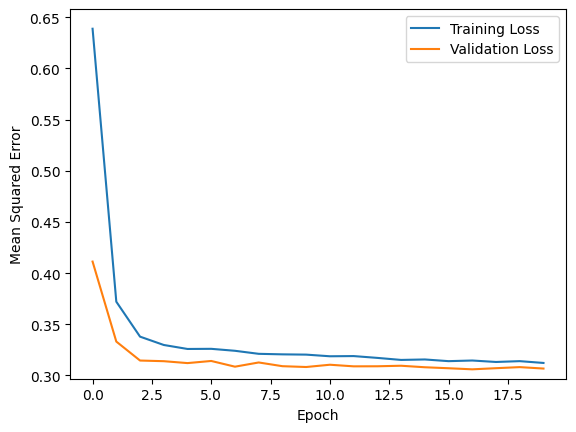


 Evaluate the new model against the test set:
3/3 [==============================] - 0s 4ms/step - loss: 0.3441 - mean_squared_error: 0.3441


{'loss': 0.3440684378147125, 'mean_squared_error': 0.3440684378147125}

In [16]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_df, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(np.array(test_features.pop(label_name))) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

## Task 1: Compare the two models

How did the deep neural net perform against the baseline linear regression model?

## Tarea 1: Comparar los dos modelos

¿Cómo se desempeñó la red neuronal profunda en comparación con el modelo de regresión lineal de referencia?

In [12]:
# Assuming that the linear model converged and
# the deep neural net model also converged, please
# compare the test set loss for each.
# In our experiments, the loss of the deep neural
# network model was consistently lower than
# that of the linear regression model, which
# suggests that the deep neural network model
# will make better predictions than the
# linear regression model.


# Suponiendo que el modelo lineal convergió y que el modelo de red neuronal profunda también convergió, 
# por favor compara la pérdida en el conjunto de prueba para cada uno. 
# En nuestras pruebas, la pérdida del modelo de red neuronal profunda fue consistentemente menor que la del modelo de regresión lineal, 
# lo que sugiere que el modelo de red neuronal profunda hará predicciones mejores que el modelo de regresión lineal.

## Task 2: Optimize the deep neural network's topography

Experiment with the number of layers of the deep neural network and the number of nodes in each layer.  Aim to achieve both of the following goals:

*  Lower the loss against the test set.
*  Minimize the overall number of nodes in the deep neural net.

The two goals may be in conflict.

## Tarea 2: Optimizar la topografía de la red neuronal profunda

Experimenta con el número de capas de la red neuronal profunda y el número de nodos en cada capa. Intenta lograr ambos de los siguientes objetivos:

* Reducir la pérdida contra el conjunto de prueba.
* Minimizar el número total de nodos en la red neuronal profunda.

Estos dos objetivos pueden estar en conflicto entre sí.

In [13]:
# Many answers are possible.  We noticed the
# following trends:
#   * Two layers outperformed one layer, but
#     three layers did not perform significantly
#     better than two layers.
#     In other words, two layers seemed best.
#   * Setting the topography as follows produced
#     reasonably good results with relatively few
#     nodes:
#       * 10 nodes in the first layer.
#       *  6 nodes in the second layer.
#     As the number of nodes in each layer dropped
#     below the preceding, test loss increased.
#     However, depending on your application, hardware
#     constraints, and the relative pain inflicted
#     by a less accurate model, a smaller network
#     (for example, 6 nodes in the first layer and
#     4 nodes in the second layer) might be
#     acceptable.

# Muchas respuestas son posibles. Observamos las siguientes tendencias:
#   * Dos capas tuvieron un rendimiento mejor que una capa, pero
#     tres capas no tuvieron un rendimiento significativamente
#     mejor que dos capas.
#     En otras palabras, dos capas parecían ser las mejores.
#   * Configurar la topografía de la siguiente manera produjo
#     resultados razonablemente buenos con relativamente pocos
#     nodos:
#       * 10 nodos en la primera capa.
#       * 6 nodos en la segunda capa.
#     A medida que el número de nodos en cada capa disminuía
#     por debajo del anterior, la pérdida en la prueba aumentaba.
#     Sin embargo, dependiendo de tu aplicación, restricciones de hardware
#     y el dolor relativo infligido por un modelo menos preciso, una red
#     más pequeña (por ejemplo, 6 nodos en la primera capa y
#     4 nodos en la segunda capa) podría ser aceptable.